In [1]:
import numpy as np
from numpy.random import multivariate_normal
import scipy as scp
import sklearn
from scipy.sparse.csgraph import laplacian as sp_laplacian
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import mutual_info_score as mi
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

N_SAMPLES = 1000

In [2]:
def get_synth_data():
    c1_means = [[1, 1],[1, 2],[1, 1]]
    c2_means = [[3, 4],[2, 2],[3, 3]]
    c1_cov = list()
    c1_cov.append([[1, 0.5],[0.5, 1.5]])
    c1_cov.append([[1, -0.2],[-0.2, 1]])
    c1_cov.append([[1.2, 0.2],[0.2, 1]])
    c2_cov = list()
    c2_cov.append([[0.3, 0.2],[0.2, 0.6]])
    c2_cov.append([[0.6, 0.1],[0.1, 0.5]])
    c2_cov.append([[1, 0.4],[0.4, 0.7]])
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    v_data =  [[],[],[]]
    
    for co in range(2):
        for vi in range(3):
            samples = multivariate_normal(means[co][vi], cov[co][vi], N_SAMPLES)
            v_data[vi].append(samples)
            
    for vi in range(3):
        v_data[vi] = np.vstack(v_data[vi])
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    for vi in range(3):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

In [3]:
def get_synth_data2():
    c1_means = [[-3, 1],[-5, 2],[-9, 1]]
    c2_means = [[3, 4],[2, 2],[3, 3]]
    c1_cov = list()
    c1_cov.append([[1, 0.5],[0.5, 1.5]])
    c1_cov.append([[1, -0.2],[-0.2, 1]])
    c1_cov.append([[1.2, 0.2],[0.2, 1]])
    c2_cov = list()
    c2_cov.append([[0.3, 0.2],[0.2, 0.6]])
    c2_cov.append([[0.6, 0.1],[0.1, 0.5]])
    c2_cov.append([[1, 0.4],[0.4, 0.7]])
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    v_data =  [[],[],[]]
    
    for co in range(2):
        for vi in range(3):
            samples = multivariate_normal(means[co][vi], cov[co][vi], N_SAMPLES)
            v_data[vi].append(samples)
            
    for vi in range(3):
        v_data[vi] = np.vstack(v_data[vi])
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    for vi in range(3):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

In [4]:
v_data, labels = get_synth_data()

In [5]:
def gaussian_sim(X_mat):
    
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    sq_dists = np.square(distances)
    #mask = (np.eye(distances.shape[0]) != 1)
    norm_dists = sq_dists  / (2 * np.median(sq_dists))
    sims = np.exp(-norm_dists)
    
    #Set elements in the diagonal to 0
    #for ind in range(samples):
    #    sims[ind, ind] = 0
    
    return sims
    
def sym(S_mat):
    mat =  (S_mat + np.transpose(S_mat))/2
    return mat + np.min(mat)

def comp_laplacian(X_mat):
    D_mat = np.diag(np.sum(X_mat, axis=1))
    D_alt = np.sqrt(np.linalg.inv(D_mat)) 
    laplacian = D_alt @ X_mat @ D_alt
    laplacian = sym(laplacian)
    return laplacian

def comp_eigs(X_mat, k):
    laplacian = comp_laplacian(X_mat)
    e_vals, e_vecs = np.linalg.eig(laplacian)
    indices = np.argsort(e_vals)[-k:]
    e_vecs = e_vecs[:,indices]
    return e_vecs


    

In [6]:
def multiview_spectral(v_data, labels, k=2, num_iter = 5):
    #Compute the similarities matrices
    sims = [gaussian_sim(dat) for dat in v_data]
    
    #Initialize matrices of eigenvectors
    U_mats = [comp_eigs(sim, k) for sim in sims]
    
    #Iteratively compute new graph similarities, laplacians, and eigenvectors
    for iter in range(num_iter):
        print(iter)
        new_sims = list()
        mat1 = U_mats[1] @ np.transpose(U_mats[1]) @ sims[0]
        new_sims.append(sym(mat1))
        mat2 = U_mats[0] @ np.transpose(U_mats[0]) @ sims[1]
        new_sims.append(sym(mat2))
        sims = new_sims
        U_mats = [comp_eigs(sim, k) for sim in sims]    
    #Row normalize 
    for view in range(len(v_data)):
        min_rows = np.min(U_mats[view], axis=1).reshape((-1, 1))
        max_rows = np.max(U_mats[view], axis=1).reshape((-1, 1))
        U_mats[view] = (U_mats[view] - min_rows) / (max_rows - min_rows)
    #Columnwise concatenation across all views
    V_mat = np.hstack(U_mats)    
    kmeans = KMeans(n_clusters=k, n_init=100)
    clusters = kmeans.fit_predict(V_mat)
    return clusters
    

In [7]:
clusters = multiview_spectral(v_data[:2], labels, k=2)


0
1
2
3
4


C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [8]:
score = nmi(labels, clusters)
print(score)

0.5825437299699217


In [9]:
score = f1_score(labels, clusters)
print(score)

0.9161415414444982


In [10]:
print()
print(clusters.sum())


1063


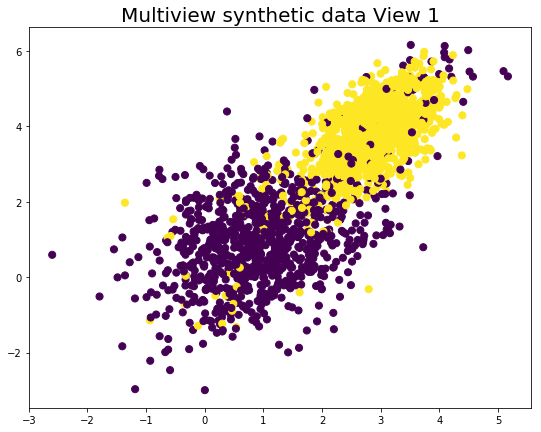

In [11]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview synthetic data View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=clusters,s=dot_size, cmap=cmap)

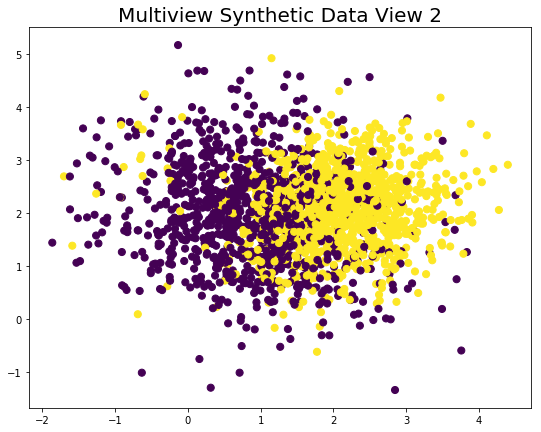

In [12]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview Synthetic Data View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=clusters,s=dot_size, cmap=cmap)

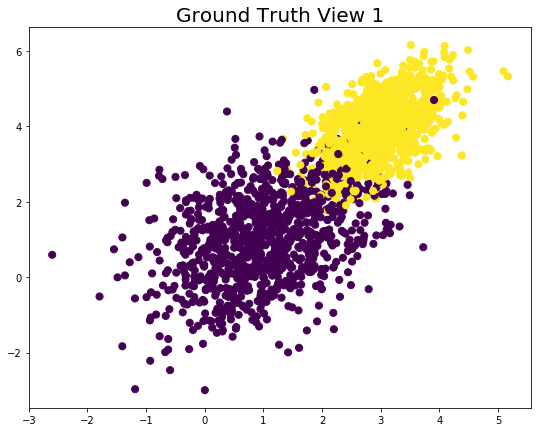

In [13]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=labels,s=dot_size, cmap=cmap)

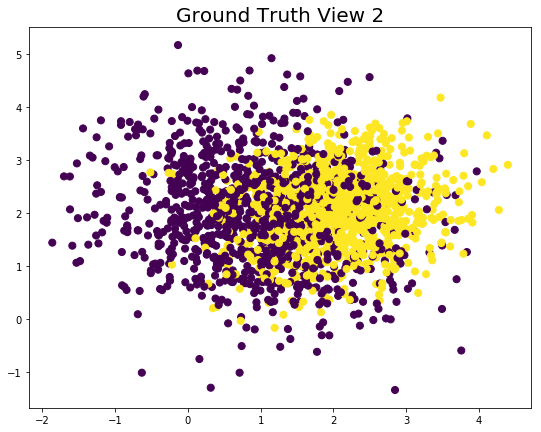

In [14]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=labels,s=dot_size, cmap=cmap)

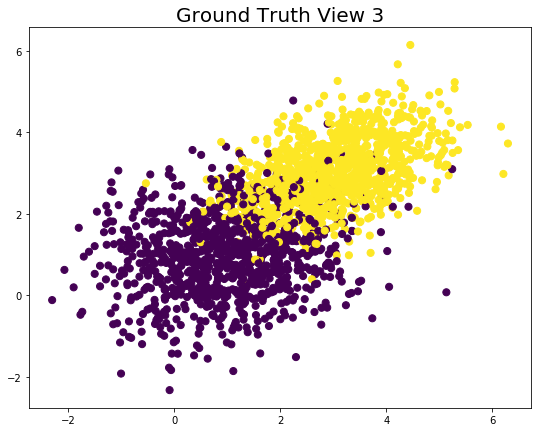

In [15]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 3', size=20)
ax.scatter(v_data[2][:, 0], v_data[2][:, 1],c=labels,s=dot_size, cmap=cmap)

In [16]:
def get_dist(X_mat):
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    return distances

distances = get_dist(v_data[0])
mask = (np.eye(distances.shape[0]) != 1)
g= 1/ (2 * np.median(distances[mask]) **2)
print(g)
cluster = SpectralClustering(n_clusters=2, gamma = g, n_jobs = -1)
pred = cluster.fit(v_data[0])
affinity = cluster.affinity_matrix_
aff = gaussian_sim(v_data[0])
print(affinity)
print(aff)

0.09237961833447927
[[1.         0.67577016 0.19475146 ... 0.33692543 0.95408612 0.84900007]
 [0.67577016 1.         0.46610064 ... 0.72534506 0.62147082 0.94972111]
 [0.19475146 0.46610064 1.         ... 0.90539509 0.12499352 0.34983762]
 ...
 [0.33692543 0.72534506 0.90539509 ... 1.         0.24760475 0.57950514]
 [0.95408612 0.62147082 0.12499352 ... 0.24760475 1.         0.80501411]
 [0.84900007 0.94972111 0.34983762 ... 0.57950514 0.80501411 1.        ]]
[[1.         0.67548413 0.19440758 ... 0.33652971 0.95403768 0.84884995]
 [0.67548413 1.         0.46571644 ... 0.7250935  0.62115157 0.94966818]
 [0.19440758 0.46571644 1.         ... 0.90529789 0.12471305 0.34944093]
 ...
 [0.33652971 0.7250935  0.90529789 ... 1.         0.24723165 0.5791637 ]
 [0.95403768 0.62115157 0.12471305 ... 0.24723165 1.         0.80482552]
 [0.84884995 0.94966818 0.34944093 ... 0.5791637  0.80482552 1.        ]]


In [17]:
#Single view scikit learn results 

#View 1
distances1 = get_dist(v_data[0])
g1= 1/ (2 * np.median(distances1) **2)
S_Cluster = SpectralClustering(n_clusters=2, gamma = g1)
v1_clusters = S_Cluster.fit_predict(v_data[0]) 
v1_score = nmi(labels, v1_clusters)
print("NMI for view 1 is " + str(v1_score))


#View 2
distances2 = get_dist(v_data[1])
g2= 1/ (2 * np.median(distances2) **2)
S_Cluster = SpectralClustering(n_clusters=2, gamma = g2)
v2_clusters = S_Cluster.fit_predict(v_data[1]) 
v2_score = nmi(labels, v2_clusters)
print("NMI for view 2 is " + str(v2_score))


#View 3
distances3 = get_dist(v_data[2])
g3= 1/ (2 * np.median(distances3) **2)
S_Cluster = SpectralClustering(n_clusters=2, gamma = g3)
v3_clusters = S_Cluster.fit_predict(v_data[2]) 
v3_score = nmi(labels, v3_clusters)
print("NMI for view 3 is " + str(v3_score))


NMI for view 1 is 0.7098862402750175
NMI for view 2 is 0.17920262964368727
NMI for view 3 is 0.540642147900966


In [18]:
U_SAMPLES = 200

def get_dist(X_mat):
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    return distances

def get_UCI():
    
    fac_file = 'fac.txt'
    fou_file = 'fou.txt'
    fac_feats = np.loadtxt(fac_file, delimiter=',')
    fou_feats = np.loadtxt(fou_file, delimiter=',')
    v_data = [fou_feats, fac_feats]
    
    labels = list()
    for ind in range(10):
        labels.append(np.ones(U_SAMPLES,) * ind)
    labels = np.concatenate(labels)
    print(labels.shape)
    
        
    shuffle_inds = np.random.permutation(U_SAMPLES* 10)
    for vi in range(2):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    return v_data, labels

In [19]:
v_data, labels = get_UCI()

OSError: fac.txt not found.

In [ ]:
#Single view scikit learn results 

#View 1
distances1 = get_dist(v_data[0])
g1= 1/ (2 * np.median(distances1) **2)
S_Cluster = SpectralClustering(n_clusters=10, gamma = g1)
v1_clusters = S_Cluster.fit_predict(v_data[0]) 
v1_score = nmi(labels, v1_clusters)
print("NMI for view 1 is " + str(v1_score))


#View 2
distances2 = get_dist(v_data[1])
g2= 1/ (2 * np.median(distances2) **2)
S_Cluster = SpectralClustering(n_clusters=10, gamma = g2)
v2_clusters = S_Cluster.fit_predict(v_data[1]) 
v2_score = nmi(labels, v2_clusters)
print("NMI for view 2 is " + str(v2_score))

In [ ]:
clusters = multiview_spectral(v_data, labels, k=10)
score = nmi(labels, clusters)
print(score)

In [ ]:
tsne = TSNE()
new_data_1 = tsne.fit_transform(v_data[0])
new_data_2 = tsne.fit_transform(v_data[1])

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview UCI View 1', size=20)
ax.scatter(new_data_1[:, 0], new_data_1[:, 1],c=clusters,s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Single View UCI View 1', size=20)
ax.scatter(new_data_1[:, 0], new_data_1[:, 1],c=v1_clusters,s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('UCI Ground Truth View 1', size=20)
ax.scatter(new_data_1[:, 0], new_data_1[:, 1],c=labels,s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview UCI View 2', size=20)
ax.scatter(new_data_2[:, 0], new_data_2[:, 1],c=clusters,s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Single View UCI View 2', size=20)
ax.scatter(new_data_2[:, 0], new_data_2[:, 1],c=v2_clusters,s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('UCI Ground Truth View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=labels,s=dot_size, cmap=cmap)